# Image segmentation and forced photometry

Since the primary aim of the `Band_Data` and `Data` classes we have recently been looking at is to produce a [Catalogue](../catalogue.rst) of sources, we will also need to be able to identify one object from another. This is done in a process known as segmentation, and in principle is quite challenging to do well, although we will have a go here.

## Example 1: Making segmentation maps with SExtractor

The first technique we will use to segment the data into different sources, which is the default in galfind, is to use the SExtractor parameters from Adams et al. 2023. Before starting this example please ensure that this is installed appropriately on your computer; an explanation of how to install SExtractor can be found [here](../getting_started/installation.rst). Let's start by instantiating our JOF data object as before.

In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
from galfind import config, Data
from galfind.Data import morgan_version_to_dir

survey = "JOF"
version = "v11"
instrument_names = ["NIRCam"]

JOF_data = Data.from_survey_version(
    survey = survey,
    version = version,
    instrument_names = instrument_names, 
    version_to_dir_dict = morgan_version_to_dir,
)

Reading GALFIND config file from: /nvme/scratch/work/austind/GALFIND/galfind/../configs/galfind_config.ini
Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 14-10-2024 from 10:30 to 12:30 (CEST)


To look at what exactly the segmentation process is doing, we will try it on the F444W band only. To do this, we will first have to load in the aperture diameters.

In [ ]:
aper_diams = [0.32, 0.5, 1.0, 1.5, 2.0] * u.arcsec
JOF_data.load_aper_diams(aper_diams)

F444W_JOF = JOF_data["F444W"]

INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F090W
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F115W
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F150W
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F162M
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F182M
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F200W
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F210M
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F250M
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F277W
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F300M
INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F335M
INFO:galfi

We will now segment the F444W JOF imaging. This will take a little while as SExtractor is running; the output will be stored in the config `SExtractor/SEX_DIR` directory when it has finished under the appropriate survey/version/instrument sub-directories (which in this case this is JOF/v11/NIRCam).

In [ ]:
F444W_JOF_2 = deepcopy(F444W_JOF)
F444W_JOF_3 = deepcopy(F444W_JOF)
F444W_JOF_4 = deepcopy(F444W_JOF)
F444W_JOF_5 = deepcopy(F444W_JOF)

F444W_JOF.segment()
print(F444W_JOF)

****************************************
NIRCam/F444W BAND DATA:
----------
SURVEY: JOF
VERSION: v11
PIX SCALE: 0.03 arcsec
ZP: 28.086519392283982
SHAPE: (4464, 10244)
APERTURE DIAMETERS: [0.32 0.5  1.   1.5  2.  ] arcsec
IM PATH: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas/jw04210-o001_t002_nircam_clear-f444w_i2dnobg.fits[1]
RMS ERR PATH: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas/jw04210-o001_t002_nircam_clear-f444w_i2dnobg.fits[2]
WHT PATH: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas/jw04210-o001_t002_nircam_clear-f444w_i2dnobg.fits[4]
SEG PATH: /raid/scratch/work/austind/GALFIND_WORK/SExtractor/NIRCam/v11/JOF/MAP_RMS/segmentation/JOF_F444W_F444W_sel_cat_v11_seg.fits
SEG ARGS: {'err_type': 'rms_err', 'method': 'sextractor', 'config_name': 'default.sex', 'params_name': 'default.param'}
****************************************



In addition to the segmentation map, this function will additionally produce a background map and photometric catalogue with fluxes (from sources selected in the same band) in apertures set by the `SExtractor/APER_DIAMS` parameter in the config file. The `seg_path` and the method used to measure this will be saved inside the `Band_Data` class for future access. 

Now let's say we wanted to load the path to the segmentation map rather than making it. We can simply run this function again on a fresh `Band_Data` object, and if the required file already exists it will load the path to it.

In [4]:
F444W_JOF_2.segment()

We see from above that SExtractor is not called here. If we wanted to re-run this segmentation map for whatever reason, there are two possible actions we could take:

1. Delete or move the saved segmentation map manually
2. Pass `overwrite=True` into the `segment` function on a pre-segmented object

Option 2 is the preferred, and probably more straight forward, choice to make here. Below is its implementation.

In [5]:
# re-segment using SExtractor
F444W_JOF_3.segment(overwrite=False) # True

Excellent! We have overwritten the original segmentation map, albeit with the exact same SExtractor output. Next we will produce a segmentation map using the stored `wht` map rather than the `rms_err` map by changing the `err_type` attribute from the default `rms_err` to `wht`. 

In [6]:
F444W_JOF_4.segment("wht", overwrite=False) # True
print(F444W_JOF_4)

****************************************
NIRCam/F444W BAND DATA:
----------
SURVEY: JOF
VERSION: v11
PIX SCALE: 0.03 arcsec
ZP: 28.086519392283982
SHAPE: (4464, 10244)
APERTURE DIAMETERS: [0.32 0.5  1.   1.5  2.  ] arcsec
IM PATH: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas/jw04210-o001_t002_nircam_clear-f444w_i2dnobg.fits[1]
RMS ERR PATH: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas/jw04210-o001_t002_nircam_clear-f444w_i2dnobg.fits[2]
WHT PATH: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas/jw04210-o001_t002_nircam_clear-f444w_i2dnobg.fits[4]
SEG PATH: /raid/scratch/work/austind/GALFIND_WORK/SExtractor/NIRCam/v11/JOF/MAP_WEIGHT/segmentation/JOF_F444W_F444W_sel_cat_v11_seg.fits
SEG ARGS: {'err_type': 'wht', 'method': 'sextractor', 'config_name': 'default.sex', 'params_name': 'default.param'}
****************************************



This will update the segmentation map path in the `Band_Data` object for F444W and make a new segmentation map using the `wht` path, although will not actually overwrite the previously run `rms_err` map. The difference between the two maps can be seen by comparing the segmentation maps generated from the two separate weight maps.

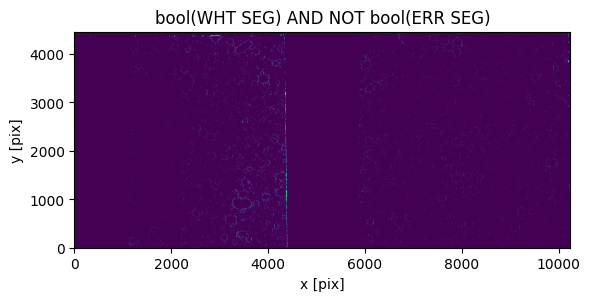

In [7]:
# load the segmentation maps
rms_err_seg = F444W_JOF.load_seg(incl_hdr = False)
wht_seg = F444W_JOF_4.load_seg(incl_hdr = False)
# plot the difference
fig, ax = plt.subplots()
ax.imshow(wht_seg.astype(bool) & ~rms_err_seg.astype(bool), origin = "lower")
ax.set_title("bool(WHT SEG) AND NOT bool(ERR SEG)")
ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")
plt.show()

Here we can see there is a minor difference between SExtractor segmentation using the ERR and WHT maps in that the WHT maps segments more of the outskirts surrounding bright objects in the wisp affected modules.

Lastly, we will regularly want to produce segmentation maps for every band used in a particular survey, for instance when running a cataloguing pipeline. As before, this takes in `err_type`, `method`, and `overwrite` arguments; we will implement the default functionality of this below.

In [8]:
JOF_data.segment(err_type="rms_err", method="sextractor", overwrite=False)
print(JOF_data)

****************************************
DATA OBJECT:
----------
SURVEY: JOF
VERSION: v11
****************************************
MULTIPLE_FILTER
----------
FACILITY: JWST
INSTRUMENT: NIRCam
FILTERS: ['F090W', 'F115W', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F410M', 'F444W']
****************************************
NIRCam COMMON ATTRIBUTES:
----------
IM DIR: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas
RMS ERR DIR: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas
WHT DIR: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas
SEG DIR: /raid/scratch/work/austind/GALFIND_WORK/SExtractor/NIRCam/v11/JOF/MAP_RMS/segmentation
IM EXT: 1
RMS ERR EXT: 2
WHT EXT: 4
ZP: 28.0865
PIX SCALE: 0.03 arcsec
DATA SHAPE: (4464, 10244)
SEG ARGS: {'err_type': 'rms_err', 'method': 'sextractor', 'config_name': 'default.sex', 'params_name': 'default.param'}
----------
****************************************
NIRCam/

## Example 2: Plotting the segmentation maps

Once the segmentation map has been created, the next step is to plot it. We use the `Data.plot()` function using the `ext = "SEG"` argument. There are a few more arguments that we write explicitly for clarity, although we note that for now we will keep these as the galfind defaults.

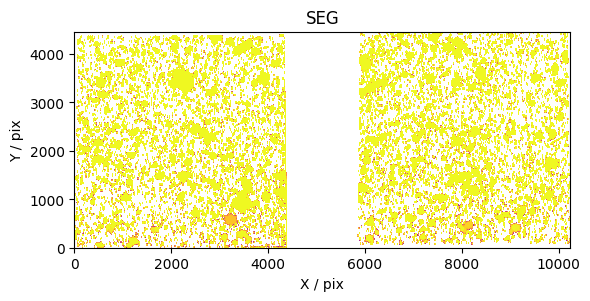

In [9]:
JOF_data["F444W"].plot(ext = "SEG", cmap = "plasma", show = True)

Maybe we also want to zoom into a specific region of the segmentation map as well to have a closer look at some specific sources. Let's change some of the default arguments now to see how this changes the output plot.

## Example 3: Running forced photometry using SExtractor

In previous notebooks and examples 1 and 2 we have seen how to load a photometric `Data` class and produce segmentation maps using SExtractor. Now we will produce a catalogue of forced photometry, required for producing photometric source catalogues.

The `perform_forced_phot()` method in `Data` and `Band_Data_Base` is used to:
1. Perform forced photometry using a specific selection band, including the possibility of using stacked data
2. Produce a photometric catalogue with aperture (and Kron) fluxes in a range of chosen aperture sizes, and other associated (currently just SExtractor) derived properties
3. Create a README for the catalogue which is updated at runtime to describe what is included (TO DO)

In [10]:
JOF_data_2 = Data.from_survey_version(
    survey = survey,
    version = version,
    instrument_names = instrument_names, 
    version_to_dir_dict = morgan_version_to_dir,
    aper_diams = aper_diams,
    forced_phot_band = ["F277W", "F356W", "F444W"],
)

INFO:galfind:Loaded aper_diams=<Quantity [0.32, 0.5 , 1.  , 1.5 , 2.  ] arcsec> for F277W+F356W+F444W


In [11]:
JOF_data_2.segment(err_type="rms_err", method="sextractor", overwrite=False)
JOF_data_2.perform_forced_phot()
print(JOF_data_2)

****************************************
DATA OBJECT:
----------
SURVEY: JOF
VERSION: v11
PHOTOMETRIC CATALOGUE: /raid/scratch/work/austind/GALFIND_WORK/Catalogues/v11/NIRCam/JOF/(0.32,0.50,1.00,1.50,2.00)as/JOF_MASTER_Sel-F277W+F356W+F444W_v11.fits
APERTURE DIAMETERS: [0.32 0.5  1.   1.5  2.  ] arcsec
SELECTION BAND: NIRCam/F277W+F356W+F444W
****************************************
MULTIPLE_FILTER
----------
FACILITY: JWST
INSTRUMENT: NIRCam
FILTERS: ['F090W', 'F115W', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M', 'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F410M', 'F444W']
****************************************
NIRCam COMMON ATTRIBUTES:
----------
IM DIR: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas
RMS ERR DIR: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas
WHT DIR: /raid/scratch/data/jwst/JOF/NIRCam/mosaic_1084_wispnathan/30mas
SEG DIR: /raid/scratch/work/austind/GALFIND_WORK/SExtractor/NIRCam/v11/JOF/MAP_RMS/segmentation
FORCED PHOT DIR: /rai

Now let's have a look at the catalogue this has produced.

In [12]:
tab = Table.read(JOF_data_2.phot_cat_path)
print(tab)

  NUMBER     X_IMAGE     Y_IMAGE   ... FLAGS_F444W ISOAREA_IMAGE_F444W
               pix         pix     ...                     pix2       
---------- ----------- ----------- ... ----------- -------------------
         1   9219.8145    743.6143 ...           2               24934
         2   6108.1621    543.1823 ...           0               15250
         3   7386.6421    518.4732 ...           2               11853
         4   8138.5957    472.6456 ...           2               21621
         5   8047.3140    369.3903 ...           3                4953
         6   9006.2188    330.5024 ...           3               10204
         7    765.8052    389.6784 ...           3               10175
         8   1647.3230    381.3969 ...           3                8131
         9   6701.1450    368.3413 ...           2                6157
        10     82.3648    355.8787 ...          18                3895
       ...         ...         ... ...         ...                 ...
     1

## Example 4: Re-configuring SExtractor

We have shown how running SExtractor can work using the default configuration, but what if we want to change this? This is rather straightforwards, as we can simply use the `config_path` argument of the `Band_Data/Stacked_Band_Data/Data` segment function. Let's have a go at this now, again for the F444W filter, also showing explicitly how the default output parameters can be changed with `params_name`. The default `params_name` is still used here, although more information regarding which output parameters are saved can be found in [the official SExtractor documentation](https://sextractor.readthedocs.io/_/downloads/en/stable/pdf/).

In [13]:
F444W_JOF_5.segment("rms_err", config_name="test1.sex", params_name="default.param")

Hmm, looks like the already run default segmentation maps are loaded in here instead of the ones we wanted to use with the updated config file. Of course we could have set `overwrite=True` in the above code block, but should we wish to compare the two SExtractor outputs we will need to keep the original data too. To get around this, we will use a new version name called `v11_test`. This will load in the `v11` data but save all of the products in `v11_test` folders. Due to this functionality, we caution the reader to not include underscores in their version names. 

In [14]:
JOF_data_test = Data.from_survey_version(
    survey = survey,
    version = f"{version}_test",
    instrument_names = instrument_names, 
    version_to_dir_dict = morgan_version_to_dir,
    aper_diams = aper_diams,
)
F444W_JOF_test = JOF_data_test["F444W"]
F444W_JOF_test.segment("rms_err", config_name="test.sex", params_name="default.param", overwrite=False) # True

That's all well and good, but what is the difference between these outputs? The difference between `default.sex` and `test.sex` is that the parameters DETECT_MINAREA, DETECT_THRESH, and ANALYSIS_THRESH have been changed. We should plot the difference to see how this impacts things. 

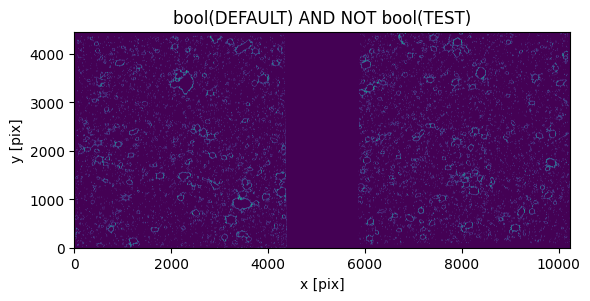

In [15]:
# load the segmentation maps
default_seg = F444W_JOF.load_seg(incl_hdr = False)
test_seg = F444W_JOF_test.load_seg(incl_hdr = False)
# plot the difference
fig, ax = plt.subplots()
ax.imshow(default_seg.astype(bool) & ~test_seg.astype(bool), origin = "lower")
ax.set_title("bool(DEFAULT) AND NOT bool(TEST)")
ax.set_xlabel("x [pix]")
ax.set_ylabel("y [pix]")
plt.show()

It should be easy to now test different SExtractor configurations iteratively until you find the parameters ideal for your specific science goals.